# Building the Hamiltonian

Lets start with specifying molecule that we simulate. Here we do this by providing list of Atom symbols and 1-D array of nuclear coordinates in atomic units.

In [15]:
pip install --force-reinstall -v "pennylane==0.27.0"

Using pip 22.1.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
  Using cached PennyLane-0.27.0-py3-none-any.whl (1.1 MB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Link requires a different Python (3.7.12 not in: '>=3.8,<3.11'): https://files.pythonhosted.org/packages/c0/ad/e3c052ed4e0027a8abef0a5e8441a044427d252d17d9aee06d56e62fc698/scipy-1.8.0rc1.tar.gz#sha256=54adf5c1197d6c3de2e131dc71660bb11d4e449aff79c8c231bd05dc6ad307eb (from https://pypi.org/simple/scipy/) (requires-python:>=3.8,<3.11)
  Link requires a different Python (3.7.12 not in: '>=3.8,<3.11'): https://files.pythonhosted.org/packages/29/d2/151a54944b333e465f98804dced31dab1284f3c37b752b9cefa710b64681/scipy-1.8.0rc2.tar.gz#sha256=d73b13eb0452c178f946b4db60b27e400225df02e926609652ed67798054e77d (from https://pypi.org/simple/scipy/) (requires-python:>=3.8,<3.11)
  Link requires a different Python (3.7.12 not in: '>=3.8,<3.11'): https://files.pythonhosted.org/packages/e4/26/83dd1c6378513a6241d98

In [16]:
from pennylane import numpy as np

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

Now build the Hamiltonian of the hydrogen molecule using the molecular_hamiltonian() function.

In [17]:
import pennylane as qml

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.24274501261018727) [Z2]
+ (-0.24274501261018727) [Z3]
+ (-0.0420725519467543) [I0]
+ (0.17771358229044493) [Z1]
+ (0.17771358229044515) [Z0]
+ (0.12293330449323184) [Z0 Z2]
+ (0.12293330449323184) [Z1 Z3]
+ (0.1676833885563385) [Z0 Z3]
+ (0.1676833885563385) [Z1 Z2]
+ (0.1705975927684718) [Z0 Z1]
+ (0.17627661394239413) [Z2 Z3]
+ (-0.04475008406310666) [Y0 Y1 X2 X3]
+ (-0.04475008406310666) [X0 X1 Y2 Y3]
+ (0.04475008406310666) [Y0 X1 X2 Y3]
+ (0.04475008406310666) [X0 Y1 Y2 X3]


# Implementing the VQE algorithm

we can use PennyLane algorithms and optimizers. We begin by defining the device, in this case PennyLane’s standard qubit simulator:

In [18]:
dev = qml.device("default.qubit", wires=qubits)

Now we need to define the quantum circuit that prepares the trial state of the molecule. We want to prepare states of the form

***|Ψ(θ)⟩=cos(θ/2) |1100⟩−sin(θ/2) |0011⟩,***

where θ is the variational parameter to be optimized in order to find the best approximation to the true ground state. 
In the Jordan-Wigner 2 encoding, the first term |1100⟩ represents the Hartree-Fock (HF) state where the two electrons in the molecule occupy the lowest-energy orbitals. The second term |0011⟩ encodes a double excitation of the HF state where the two particles are excited from qubits 0, 1 to 2, 3.

to implement this, we use the hf_state() function to generate the vector representing the Hartree-Fock state.

In [19]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


Here the hf array is used by the ***BasisState*** operation to initialize the qubit register. after that, we just act with the DoubleExcitation operation on the four qubits.

In [20]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

The next step is to define the cost function to compute the expectation value of the molecular Hamiltonian in the trial state prepared by the circuit. 
We do this using the *expval()* function. The decorator syntax allows us to run the cost function as an executable QNode with the gate parameter θ:

In [21]:
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

Now we proceed to minimize the cost function to find the ground state of the H2 molecule. To start, we need to define the classical optimizer. Here we use a basic gradient-descent optimizer.

In [22]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

We initialize the circuit parameter θ to zero, meaning that we start from the Hartree-Fock state.

In [23]:
theta = np.array(0.0, requires_grad=True)

We carry out the optimization over a maximum of 100 steps aiming to reach a convergence tolerance of 10^6 for the value of the cost function.

In [24]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


Let’s plot the values of the ground state energy of the molecule and the gate parameter θ as a function of the optimization step.

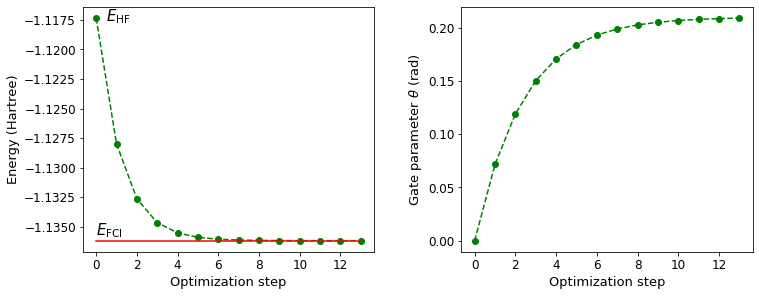

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()